# Analyse Complète du Churn - Customer Churn Modelling

## Formation Machine Learning

Ce notebook présente une analyse complète de la prédiction du churn client avec:
1. **EDA** (Exploratory Data Analysis)
2. **Cleaning & Preprocessing**
3. **Modélisation & Évaluation** (KNN, Logistic Regression, Decision Tree, Random Forest, XGBoost)
4. **Fine-tuning** des meilleurs modèles avec courbes ROC
5. **Sélection de caractéristiques** avec SelectKBest
6. **Conclusion**

In [23]:
# !pip install xgboost

In [24]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Pour l'évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Pour la sélection de features
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

---
# 1. EDA (Exploratory Data Analysis)
---

## 1.1 Chargement des données

In [25]:
# Chargement du dataset
df = pd.read_csv('Churn_Modelling.csv')

print("Shape du dataset:", df.shape)
print("\n" + "="*80)
df.head(10)

Shape du dataset: (10000, 14)



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [26]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [27]:
# Informations générales sur le dataset
print("Informations sur le dataset:")
print("="*80)
df.info()

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [28]:
# Statistiques descriptives
print("Statistiques descriptives:")
print("="*80)
df.describe().T

Statistiques descriptives:


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


## 1.2 Division des variables numériques et catégoriques

In [29]:
# Identification des colonnes à exclure de l'analyse
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']

# Séparation des variables numériques et catégoriques
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_drop and col != 'Exited']

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Variables numériques:")
print(numerical_cols)
print(f"\nNombre de variables numériques: {len(numerical_cols)}")
print("\n" + "="*80)
print("\nVariables catégoriques:")
print(categorical_cols)
print(f"\nNombre de variables catégoriques: {len(categorical_cols)}")

Variables numériques:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Nombre de variables numériques: 8


Variables catégoriques:
['Surname', 'Geography', 'Gender']

Nombre de variables catégoriques: 3


## 1.3 Vérification des valeurs manquantes

In [30]:
# Vérification des valeurs manquantes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valeurs_Manquantes': missing_values,
    'Pourcentage': missing_percentage
})

missing_df = missing_df[missing_df['Valeurs_Manquantes'] > 0].sort_values(
    'Valeurs_Manquantes', ascending=False
)

if len(missing_df) > 0:
    print("Valeurs manquantes détectées:")
    print(missing_df)
else:
    print("✓ Aucune valeur manquante détectée dans le dataset!")

✓ Aucune valeur manquante détectée dans le dataset!


## 1.4 Analyse de la variable cible (Exited)

Distribution de la variable cible 'Exited':

Nombre de clients restés (0): 7963 (79.63%)
Nombre de clients partis (1): 2037 (20.37%)


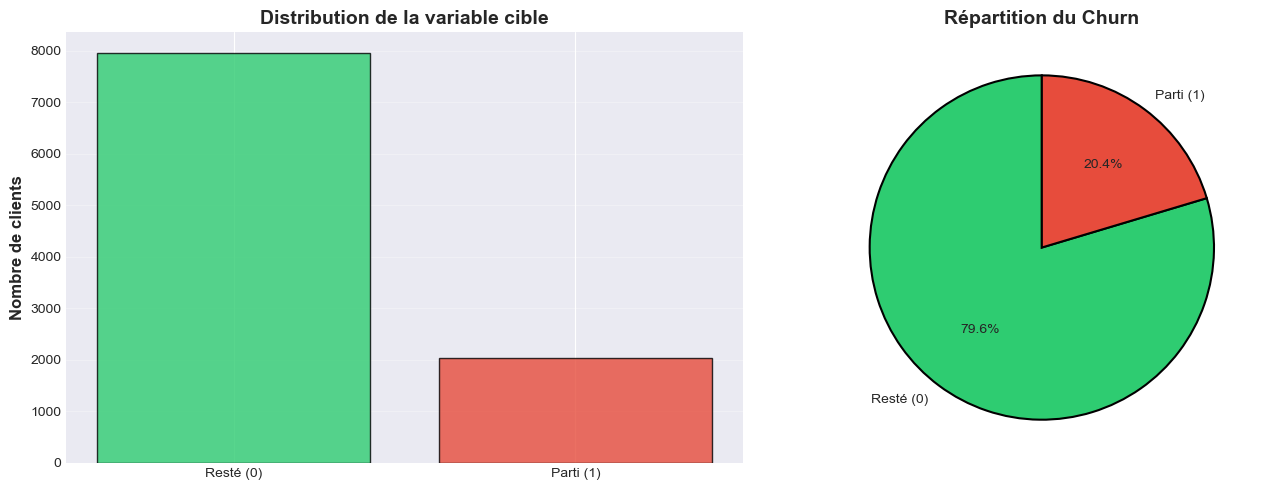

In [31]:
# Distribution de la variable cible
target_counts = df['Exited'].value_counts()
target_percentage = df['Exited'].value_counts(normalize=True) * 100

print("Distribution de la variable cible 'Exited':")
print("="*80)
print(f"\nNombre de clients restés (0): {target_counts[0]} ({target_percentage[0]:.2f}%)")
print(f"Nombre de clients partis (1): {target_counts[1]} ({target_percentage[1]:.2f}%)")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Resté (0)', 'Parti (1)'], target_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Nombre de clients', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution de la variable cible', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(target_counts.values, labels=['Resté (0)', 'Parti (1)'], 
           autopct='%1.1f%%', colors=colors, startangle=90,
           wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].set_title('Répartition du Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 1.5 Analyse des variables catégoriques

In [32]:
categorical_cols = ['Geography', 'Gender']


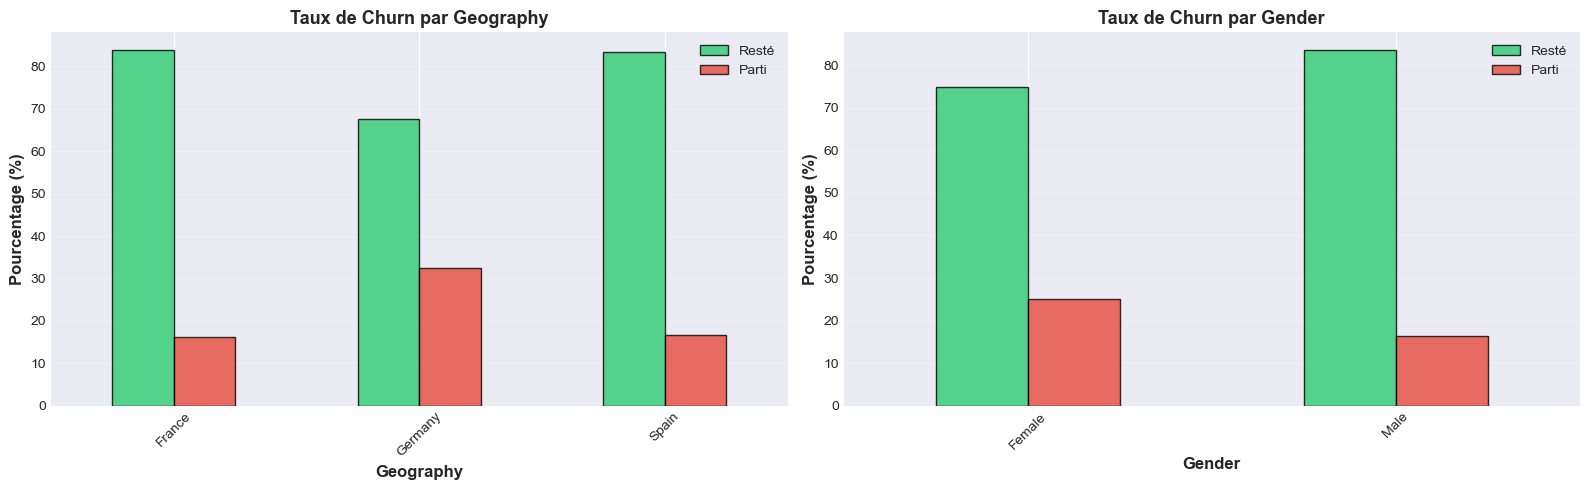

In [33]:
# Analyse du churn par variable catégorique
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, col in enumerate(categorical_cols):
    # Créer un crosstab
    ct = pd.crosstab(df[col], df['Exited'], normalize='index') * 100
    
    # Bar plot empilé
    ct.plot(kind='bar', stacked=False, ax=axes[idx], 
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
    axes[idx].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Taux de Churn par {col}', fontsize=13, fontweight='bold')
    axes[idx].legend(['Resté', 'Parti'], loc='upper right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 1.6 Distribution des variables numériques

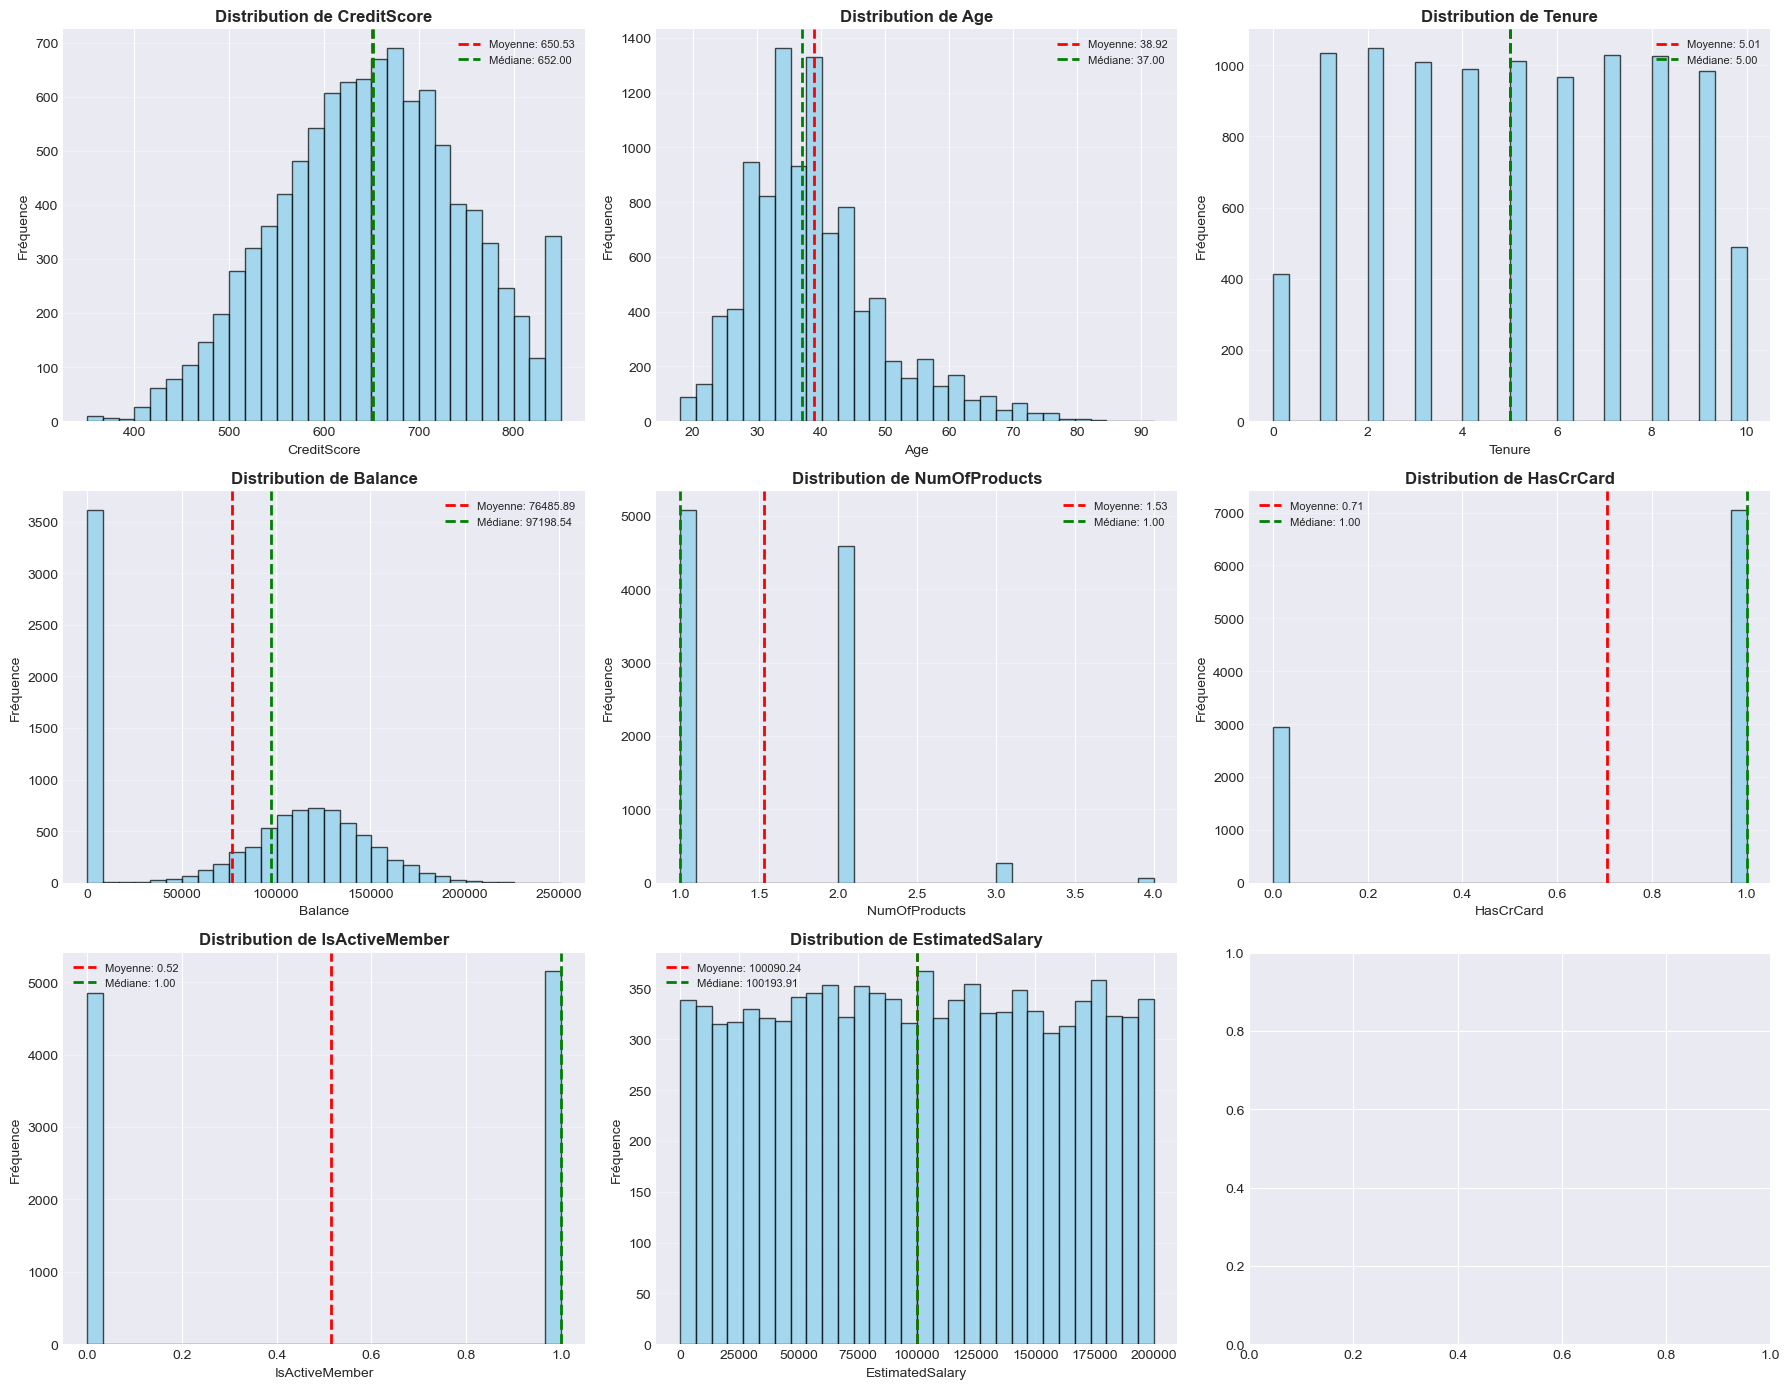

In [34]:
# Histogrammes des variables numériques
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, color='skyblue', 
                   alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Fréquence', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Statistiques
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Moyenne: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Médiane: {median_val:.2f}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

## 1.7 Box plots - Détection des outliers

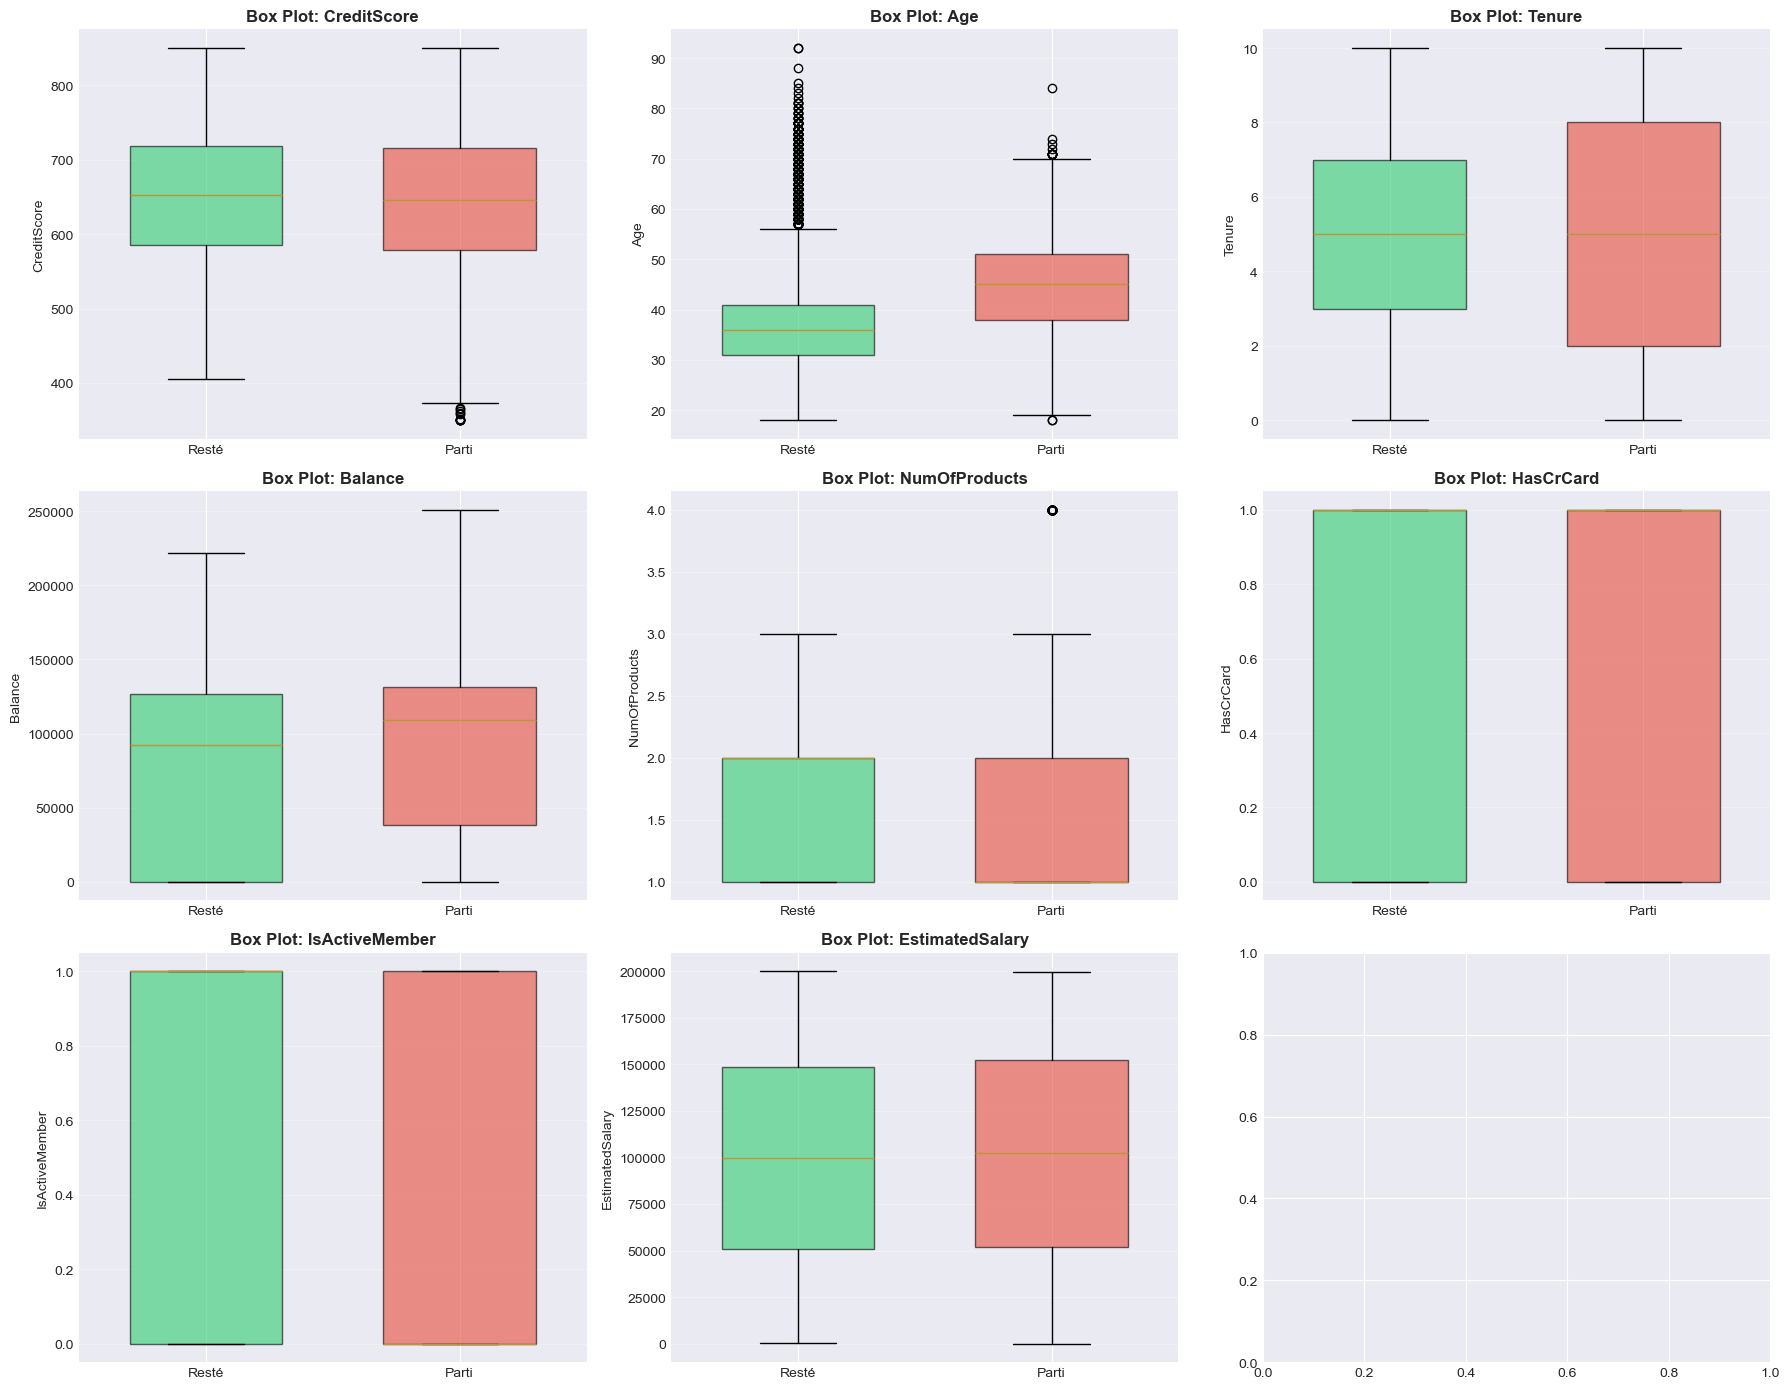

In [35]:
# Box plots pour détecter les outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    bp = axes[idx].boxplot([df[df['Exited']==0][col].dropna(), 
                            df[df['Exited']==1][col].dropna()],
                           labels=['Resté', 'Parti'],
                           patch_artist=True,
                           widths=0.6)
    
    # Colorier les box plots
    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 1.8 Matrice de corrélation

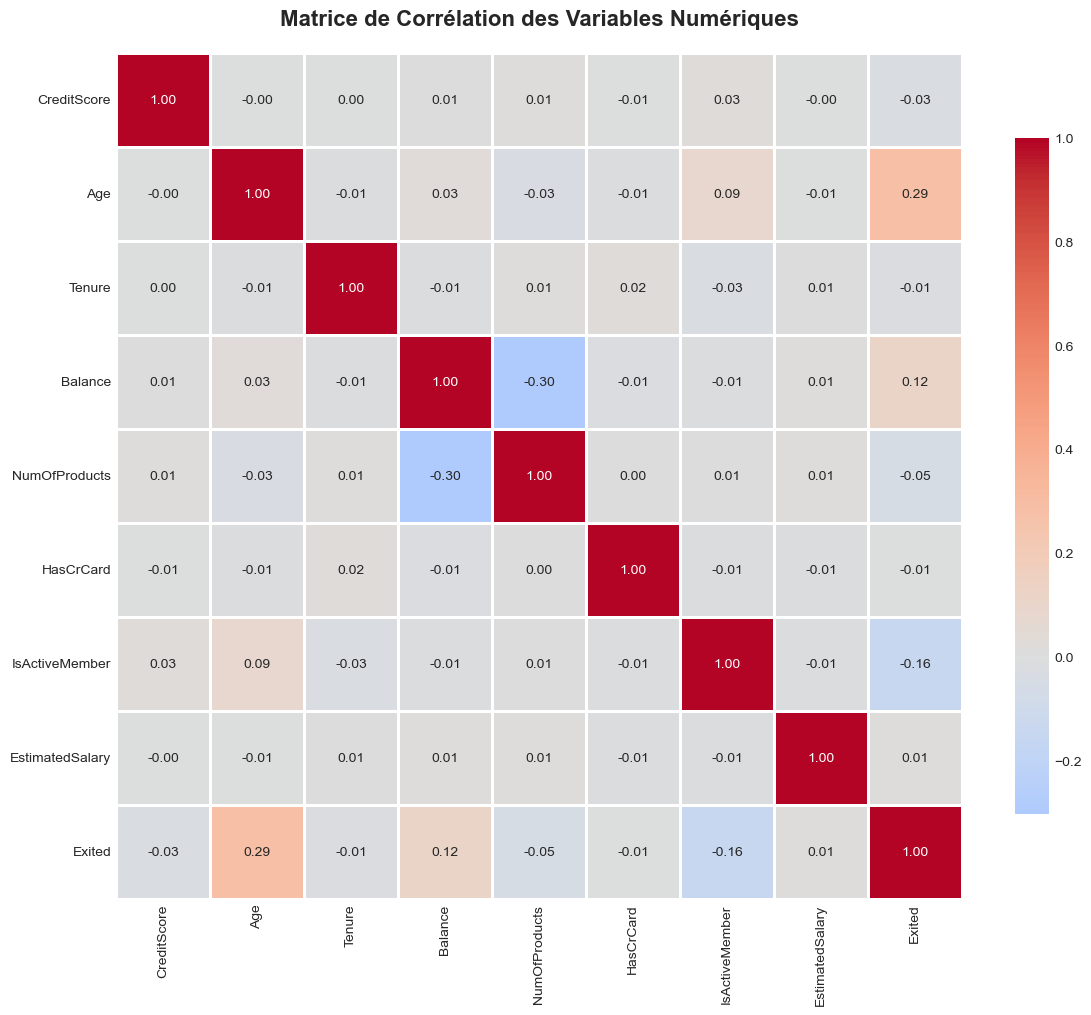


Corrélation avec la variable cible 'Exited':
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64


In [36]:
# Matrice de corrélation
correlation_cols = numerical_cols + ['Exited']
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables Numériques', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Corrélation avec la variable cible
print("\nCorrélation avec la variable cible 'Exited':")
print("="*80)
target_corr = corr_matrix['Exited'].sort_values(ascending=False)
print(target_corr[target_corr.index != 'Exited'])

## 1.9 Pairplot - Relations entre variables

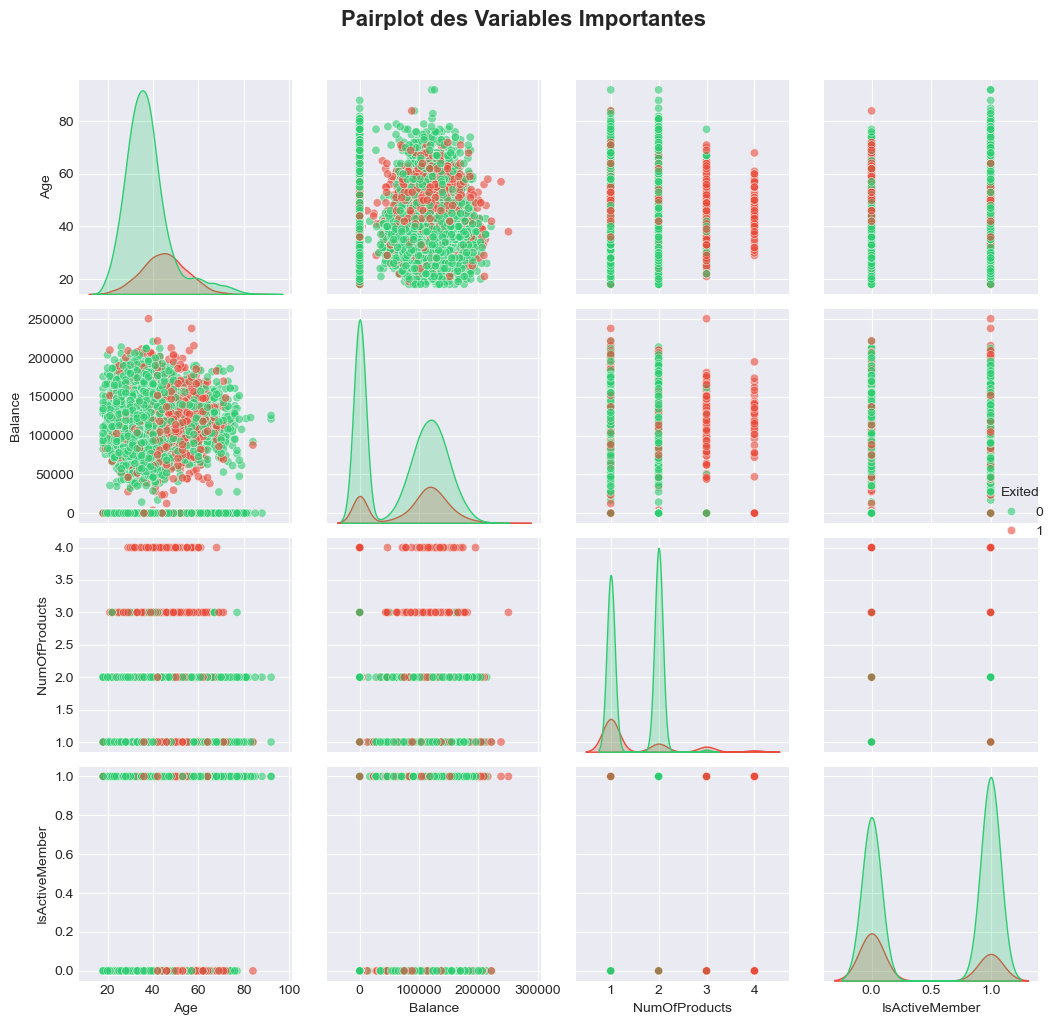

In [37]:
# Pairplot pour les variables les plus importantes
important_vars = ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Exited']
sns.pairplot(df[important_vars], hue='Exited', palette={0: '#2ecc71', 1: '#e74c3c'},
             plot_kws={'alpha': 0.6}, diag_kind='kde')
plt.suptitle('Pairplot des Variables Importantes', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
# 2. Data Cleaning & Preprocessing
---

## 2.1 Suppression des colonnes inutiles

In [38]:
# Suppression des colonnes inutiles
df_clean = df.drop(columns=cols_to_drop)
print(f"Colonnes supprimées: {cols_to_drop}")
print(f"\nShape du dataset après suppression: {df_clean.shape}")
print("\nColonnes restantes:")
print(df_clean.columns.tolist())

Colonnes supprimées: ['RowNumber', 'CustomerId', 'Surname']

Shape du dataset après suppression: (10000, 11)

Colonnes restantes:
['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


## 2.2 Encodage des variables catégoriques

In [39]:
# Label Encoding pour Gender (binaire)
le_gender = LabelEncoder()
df_clean['Gender'] = le_gender.fit_transform(df_clean['Gender'])

print("Encodage de 'Gender':")
print(dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))

# One-Hot Encoding pour Geography
df_clean = pd.get_dummies(df_clean, columns=['Geography'], prefix='Geography', drop_first=True)

print("\nOne-Hot Encoding pour 'Geography':")
print("Nouvelles colonnes créées:")
print([col for col in df_clean.columns if 'Geography' in col])

print(f"\nShape finale après encodage: {df_clean.shape}")

Encodage de 'Gender':
{'Female': np.int64(0), 'Male': np.int64(1)}

One-Hot Encoding pour 'Geography':
Nouvelles colonnes créées:
['Geography_Germany', 'Geography_Spain']

Shape finale après encodage: (10000, 12)


In [40]:
# Affichage du dataset après preprocessing
print("Dataset après preprocessing:")
print("="*80)
df_clean.head()

Dataset après preprocessing:


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


## 2.3 Séparation des features et de la target

In [41]:
# Séparation X et y
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nNombre de features: {X.shape[1]}")
print(f"\nListe des features:")
print(X.columns.tolist())

Shape de X: (10000, 11)
Shape de y: (10000,)

Nombre de features: 11

Liste des features:
['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']


## 2.4 Split Train/Test

In [42]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split des données (80% train - 20% test):")
print("="*80)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nDistribution de la variable cible:")
print(f"Train - Resté: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"Train - Parti: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"Test - Resté: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")
print(f"Test - Parti: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")

Split des données (80% train - 20% test):
X_train shape: (8000, 11)
X_test shape: (2000, 11)
y_train shape: (8000,)
y_test shape: (2000,)

Distribution de la variable cible:
Train - Resté: 6370 (79.62%)
Train - Parti: 1630 (20.38%)
Test - Resté: 1593 (79.65%)
Test - Parti: 407 (20.35%)


## 2.5 Normalisation des données

In [43]:
# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print("="*80)
print("\nStatistiques après normalisation (X_train):")
print(f"Moyenne: {X_train_scaled.mean(axis=0).mean():.6f}")
print(f"Écart-type: {X_train_scaled.std(axis=0).mean():.6f}")

# Conversion en DataFrame pour plus de clarté
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Normalisation effectuée avec StandardScaler

Statistiques après normalisation (X_train):
Moyenne: -0.000000
Écart-type: 1.000000


---
# 3. Modélisation & Évaluation
---

## 3.1 Fonction d'évaluation

In [44]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Fonction pour évaluer les performances d'un modèle
    """
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilités pour ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Métriques
    results = {
        'Modèle': name,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1-Score': f1_score(y_test, y_pred_test),
        'ROC-AUC': roc_auc
    }
    
    # Affichage
    print(f"\n{'='*80}")
    print(f"MODÈLE: {name}")
    print(f"{'='*80}")
    
    for metric, value in results.items():
        if metric != 'Modèle':
            if value is not None:
                print(f"{metric:20s}: {value:.4f}")
            else:
                print(f"{metric:20s}: N/A")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_test)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Resté', 'Parti'],
                yticklabels=['Resté', 'Parti'])
    plt.title(f'Matrice de Confusion - {name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe', fontsize=12)
    plt.xlabel('Classe Prédite', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Rapport de classification
    print(f"\nRapport de classification:")
    print(classification_report(y_test, y_pred_test, 
                                target_names=['Resté', 'Parti']))
    
    return results

## 3.2 K-Nearest Neighbors (KNN)

Entraînement du modèle K-Nearest Neighbors...

MODÈLE: K-Nearest Neighbors
Accuracy Train      : 0.8710
Accuracy Test       : 0.8240
Precision           : 0.6222
Recall              : 0.3440
F1-Score            : 0.4430
ROC-AUC             : 0.7531


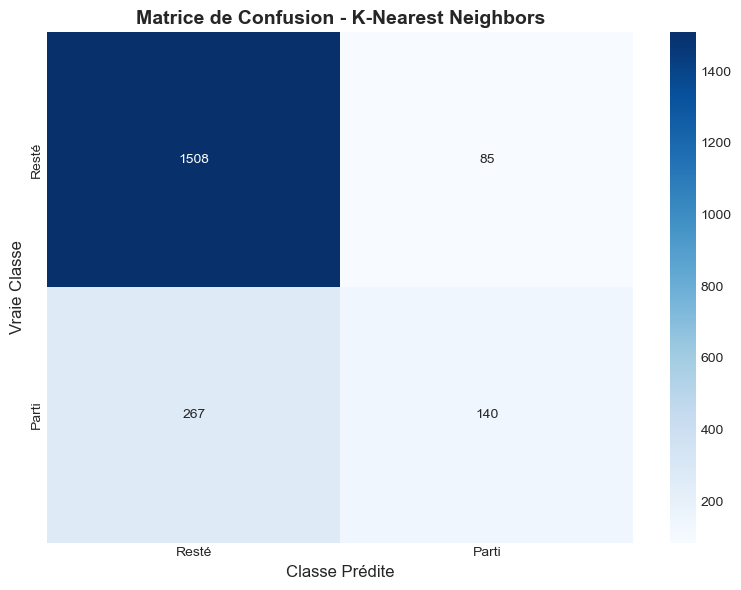


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.85      0.95      0.90      1593
       Parti       0.62      0.34      0.44       407

    accuracy                           0.82      2000
   macro avg       0.74      0.65      0.67      2000
weighted avg       0.80      0.82      0.80      2000



In [45]:
# Entraînement du modèle KNN
print("Entraînement du modèle K-Nearest Neighbors...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Évaluation
results_knn = evaluate_model('K-Nearest Neighbors', knn, 
                             X_train_scaled, X_test_scaled, 
                             y_train, y_test)

## 3.3 Logistic Regression

Entraînement du modèle Logistic Regression...

MODÈLE: Logistic Regression
Accuracy Train      : 0.8107
Accuracy Test       : 0.8080
Precision           : 0.5891
Recall              : 0.1867
F1-Score            : 0.2836
ROC-AUC             : 0.7748


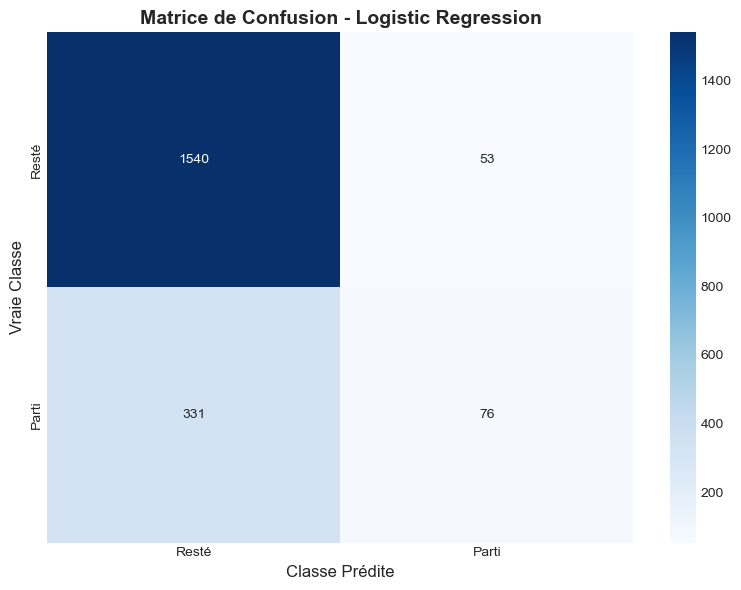


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.82      0.97      0.89      1593
       Parti       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



In [46]:
# Entraînement du modèle Logistic Regression
print("Entraînement du modèle Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Évaluation
results_lr = evaluate_model('Logistic Regression', lr, 
                            X_train_scaled, X_test_scaled, 
                            y_train, y_test)

## 3.4 Decision Tree avec visualisation

Entraînement du modèle Decision Tree...

MODÈLE: Decision Tree
Accuracy Train      : 0.8588
Accuracy Test       : 0.8560
Precision           : 0.7874
Recall              : 0.4005
F1-Score            : 0.5309
ROC-AUC             : 0.8423


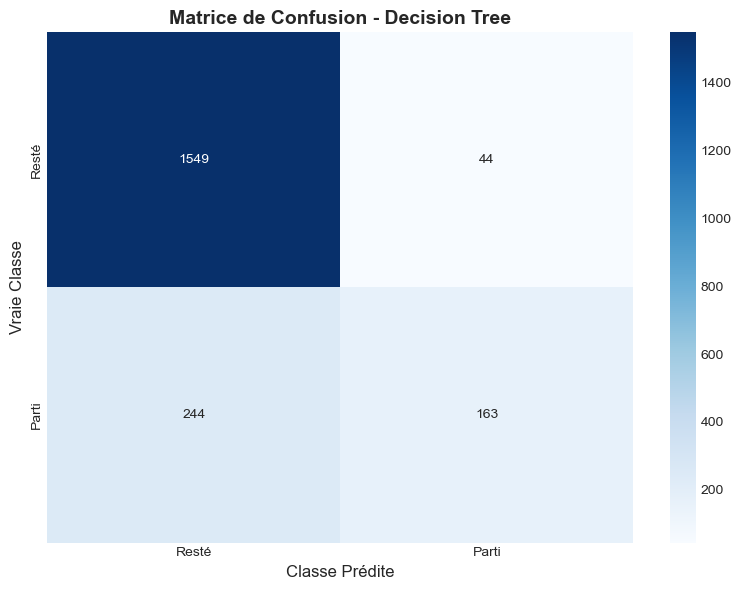


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.86      0.97      0.91      1593
       Parti       0.79      0.40      0.53       407

    accuracy                           0.86      2000
   macro avg       0.83      0.69      0.72      2000
weighted avg       0.85      0.86      0.84      2000



In [47]:
# Entraînement du modèle Decision Tree
print("Entraînement du modèle Decision Tree...")
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# Évaluation
results_dt = evaluate_model('Decision Tree', dt, 
                           X_train, X_test, 
                           y_train, y_test)

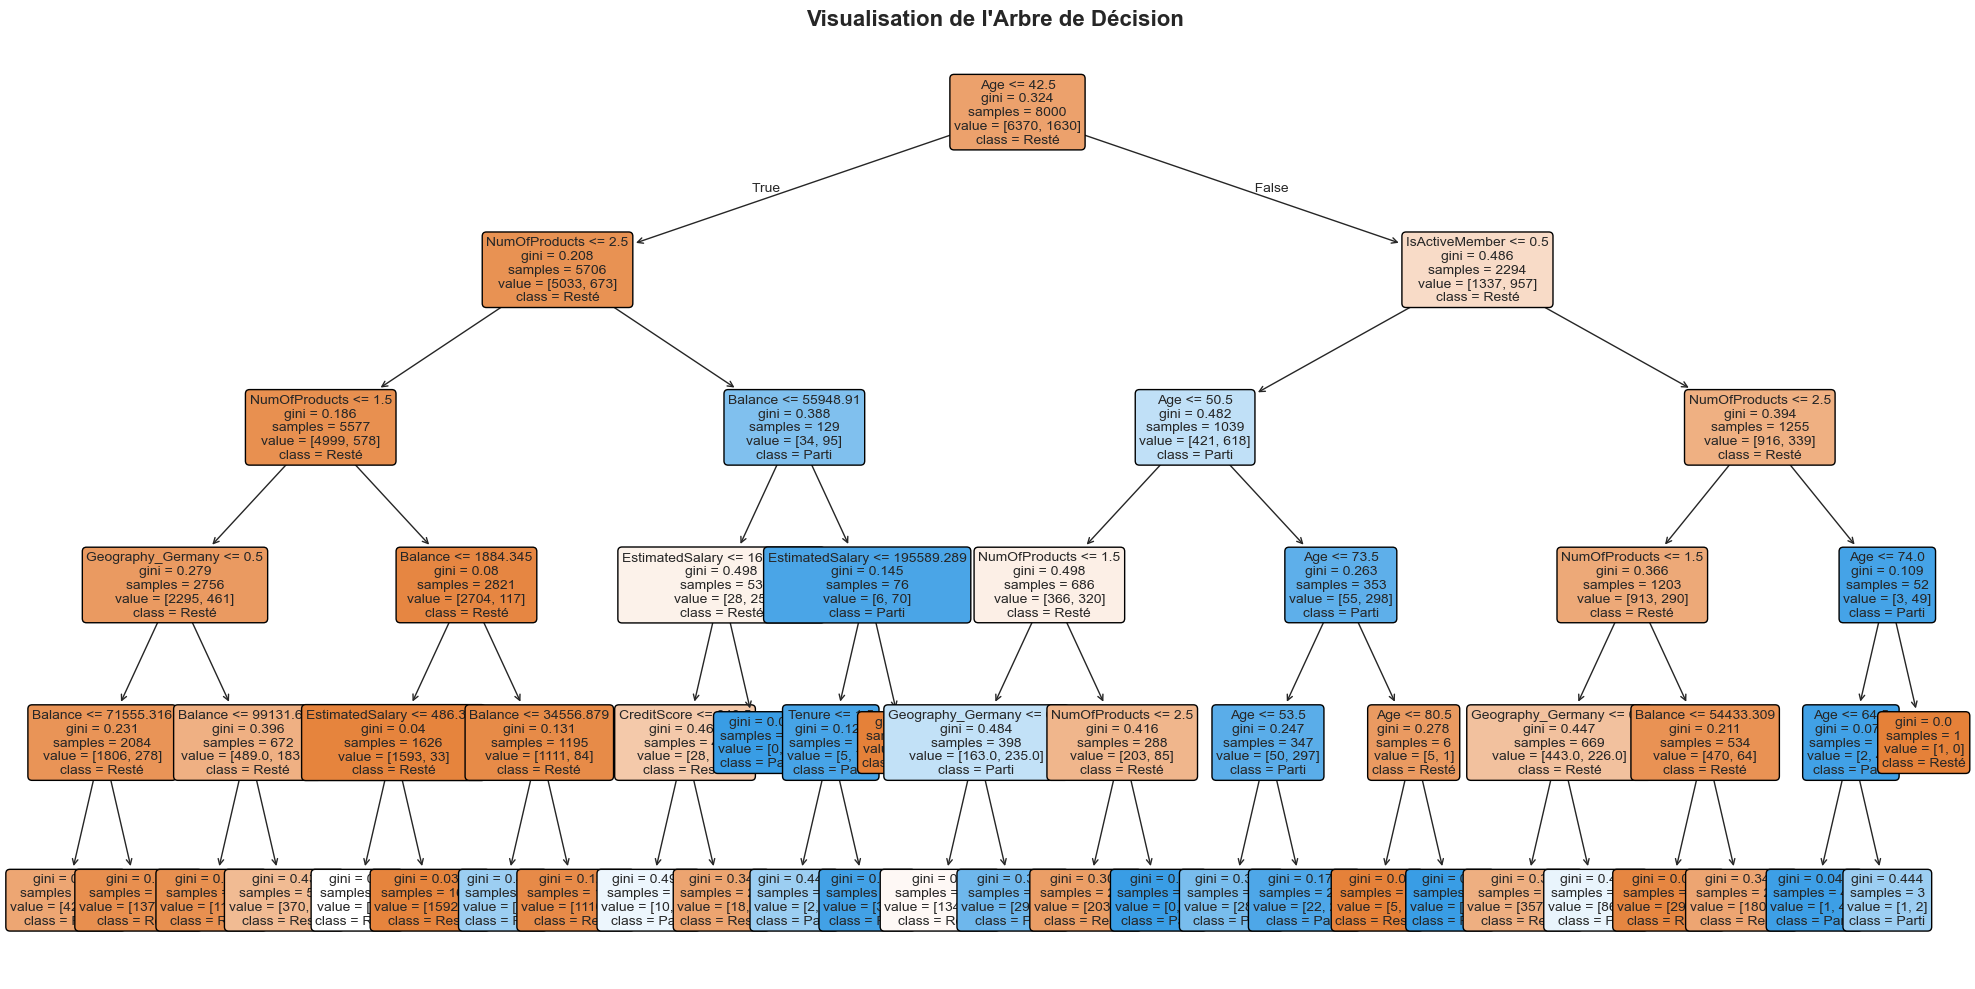

In [48]:
# Visualisation de l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=X.columns,
          class_names=['Resté', 'Parti'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Visualisation de l\'Arbre de Décision', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.5 Random Forest avec Feature Importance

Entraînement du modèle Random Forest...

MODÈLE: Random Forest
Accuracy Train      : 1.0000
Accuracy Test       : 0.8620
Precision           : 0.7695
Recall              : 0.4595
F1-Score            : 0.5754
ROC-AUC             : 0.8554


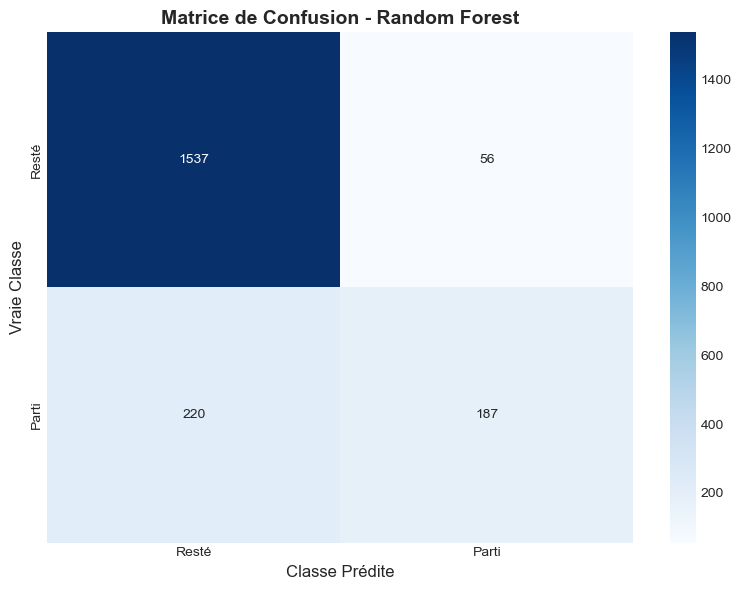


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.87      0.96      0.92      1593
       Parti       0.77      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [49]:
# Entraînement du modèle Random Forest
print("Entraînement du modèle Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Évaluation
results_rf = evaluate_model('Random Forest', rf, 
                           X_train, X_test, 
                           y_train, y_test)

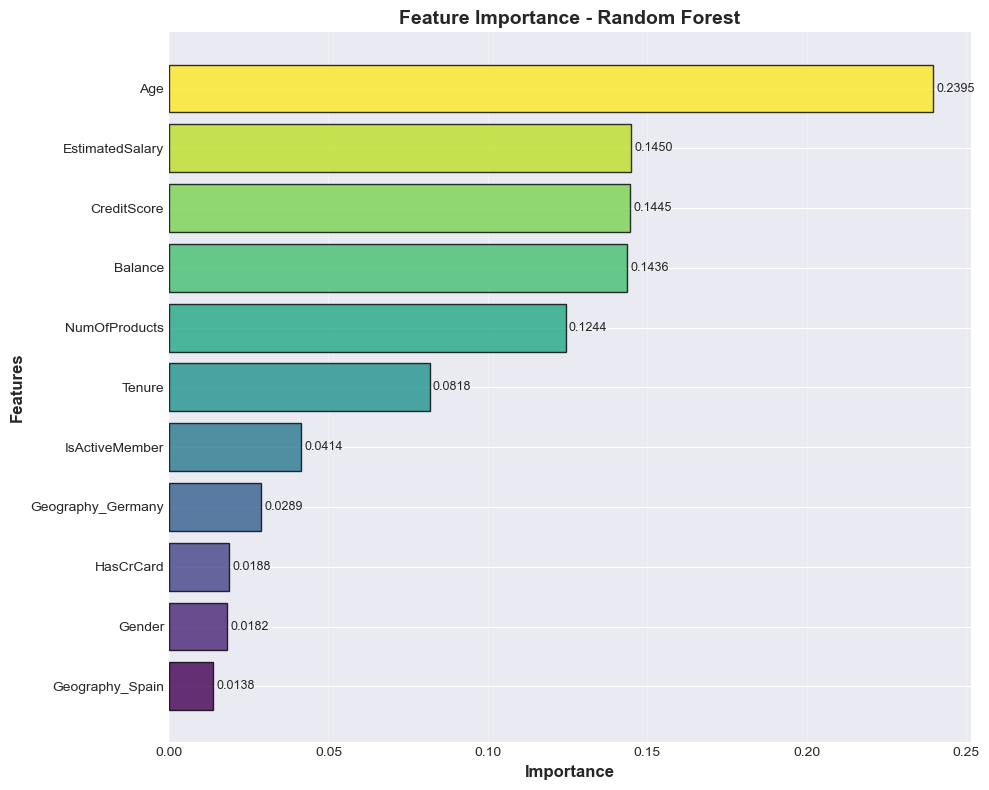


Top 5 Features les plus importantes:
        Feature  Importance
  NumOfProducts    0.124418
        Balance    0.143650
    CreditScore    0.144537
EstimatedSalary    0.144960
            Age    0.239543


In [50]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Visualisation avec barres horizontales
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 5 Features les plus importantes:")
print(feature_importance.tail(5).to_string(index=False))

## 3.6 XGBoost

Entraînement du modèle XGBoost...

MODÈLE: XGBoost
Accuracy Train      : 0.9611
Accuracy Test       : 0.8490
Precision           : 0.6829
Recall              : 0.4816
F1-Score            : 0.5648
ROC-AUC             : 0.8328


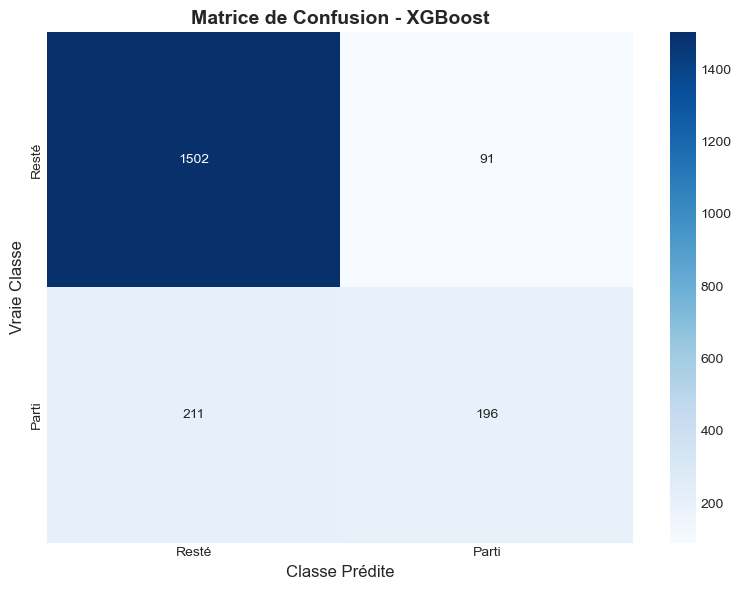


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.88      0.94      0.91      1593
       Parti       0.68      0.48      0.56       407

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000



In [51]:
# Entraînement du modèle XGBoost
print("Entraînement du modèle XGBoost...")
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Évaluation
results_xgb = evaluate_model('XGBoost', xgb, 
                            X_train, X_test, 
                            y_train, y_test)

## 3.7 Comparaison des modèles baseline


COMPARAISON DES MODÈLES BASELINE
                     Accuracy Train  Accuracy Test  Precision    Recall  F1-Score   ROC-AUC
Modèle                                                                                     
K-Nearest Neighbors        0.871000          0.824   0.622222  0.343980  0.443038  0.753076
Logistic Regression        0.810750          0.808   0.589147  0.186732  0.283582  0.774778
Decision Tree              0.858750          0.856   0.787440  0.400491  0.530945  0.842254
Random Forest              1.000000          0.862   0.769547  0.459459  0.575385  0.855440
XGBoost                    0.961125          0.849   0.682927  0.481572  0.564841  0.832834


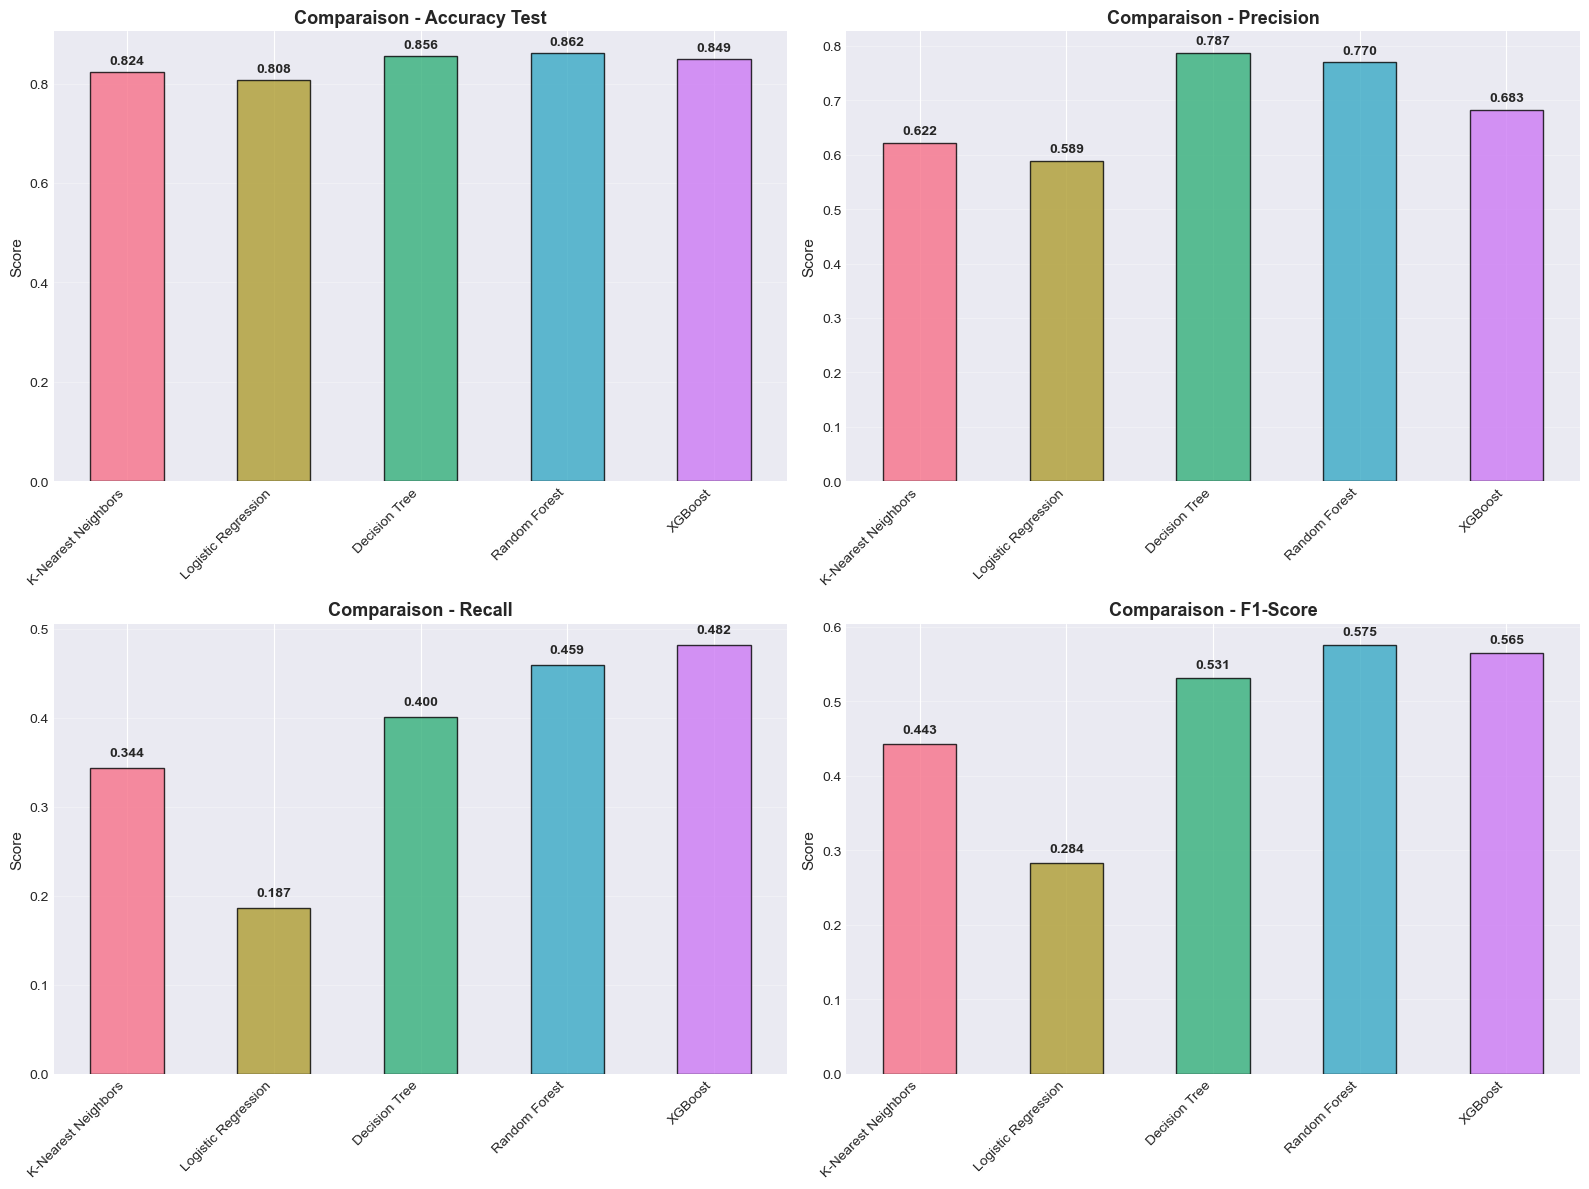

In [52]:
# Comparaison des résultats
comparison_df = pd.DataFrame([results_knn, results_lr, results_dt, results_rf, results_xgb])
comparison_df = comparison_df.set_index('Modèle')

print("\n" + "="*100)
print("COMPARAISON DES MODÈLES BASELINE")
print("="*100)
print(comparison_df.to_string())

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy Test', 'Precision', 'Recall', 'F1-Score']
colors_palette = sns.color_palette('husl', len(comparison_df))

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    
    comparison_df[metric].plot(kind='bar', ax=axes[row, col], 
                               color=colors_palette, alpha=0.8, edgecolor='black')
    axes[row, col].set_title(f'Comparaison - {metric}', fontsize=13, fontweight='bold')
    axes[row, col].set_ylabel('Score', fontsize=11)
    axes[row, col].set_xlabel('')
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(comparison_df[metric]):
        axes[row, col].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
# 4. Fine-tuning des Meilleurs Modèles
---

## 4.1 Sélection des meilleurs modèles

In [53]:
# Sélection des 3 meilleurs modèles basés sur le F1-Score
best_models_idx = comparison_df['F1-Score'].nlargest(3).index
print("Top 3 modèles sélectionnés pour le fine-tuning:")
print("="*80)
for i, model_name in enumerate(best_models_idx, 1):
    print(f"{i}. {model_name} - F1-Score: {comparison_df.loc[model_name, 'F1-Score']:.4f}")

Top 3 modèles sélectionnés pour le fine-tuning:
1. Random Forest - F1-Score: 0.5754
2. XGBoost - F1-Score: 0.5648
3. Decision Tree - F1-Score: 0.5309


## 4.2 Fine-tuning avec GridSearchCV


FINE-TUNING: Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits



Meilleurs paramètres trouvés:
  C: 1
  penalty: l2
  solver: liblinear

Meilleur score (F1) en validation croisée: 0.3169

MODÈLE: Logistic Regression (Tuned)
Accuracy Train      : 0.8107
Accuracy Test       : 0.8080
Precision           : 0.5891
Recall              : 0.1867
F1-Score            : 0.2836
ROC-AUC             : 0.7748


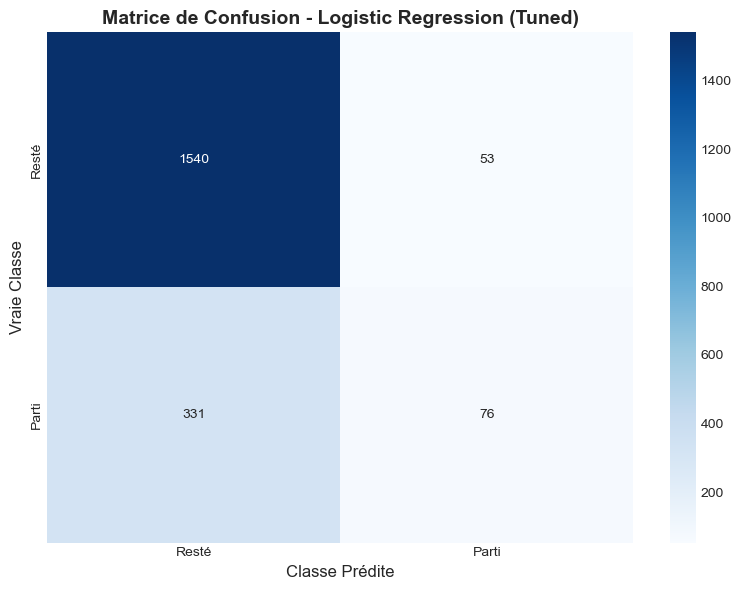


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.82      0.97      0.89      1593
       Parti       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


FINE-TUNING: Random Forest
Fitting 5 folds for each of 135 candidates, totalling 675 fits

Meilleurs paramètres trouvés:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Meilleur score (F1) en validation croisée: 0.5842

MODÈLE: Random Forest (Tuned)
Accuracy Train      : 0.9523
Accuracy Test       : 0.8635
Precision           : 0.7863
Recall              : 0.4521
F1-Score            : 0.5741
ROC-AUC             : 0.8568


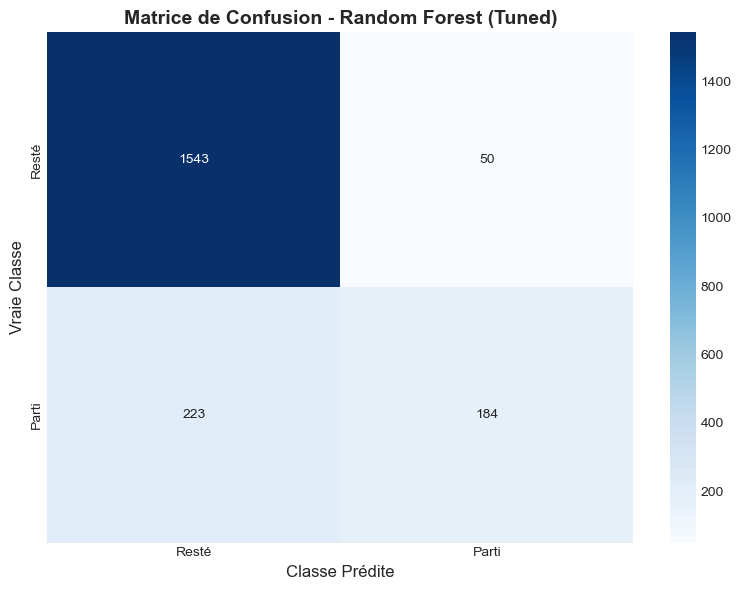


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.87      0.97      0.92      1593
       Parti       0.79      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000


FINE-TUNING: XGBoost
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Meilleurs paramètres trouvés:
  colsample_bytree: 0.9
  learning_rate: 0.3
  max_depth: 3
  n_estimators: 100
  subsample: 0.8

Meilleur score (F1) en validation croisée: 0.5973

MODÈLE: XGBoost (Tuned)
Accuracy Train      : 0.8848
Accuracy Test       : 0.8620
Precision           : 0.7510
Recall              : 0.4816
F1-Score            : 0.5868
ROC-AUC             : 0.8594


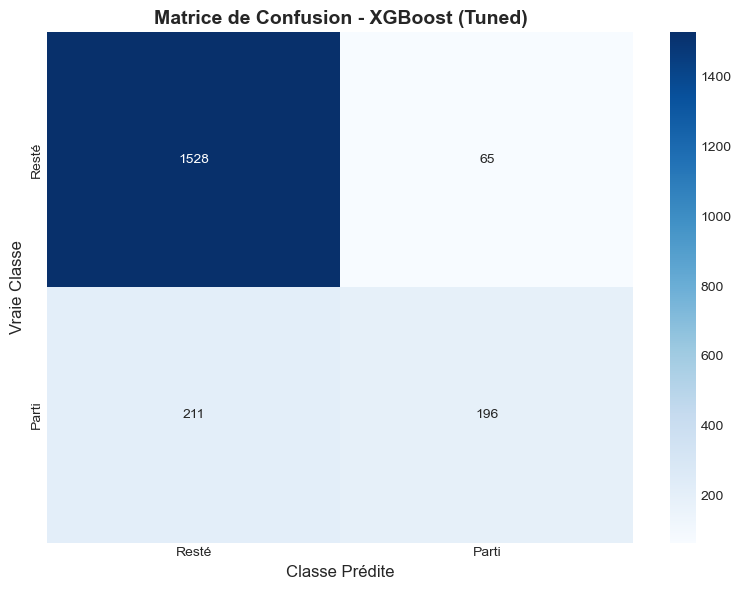


Rapport de classification:
              precision    recall  f1-score   support

       Resté       0.88      0.96      0.92      1593
       Parti       0.75      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [54]:
# Dictionnaire des modèles et paramètres à tuner
models_to_tune = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
}

# Stockage des modèles tunés
tuned_models = {}
tuned_results = []

for model_name, config in models_to_tune.items():
    print(f"\n{'='*80}")
    print(f"FINE-TUNING: {model_name}")
    print(f"{'='*80}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nMeilleurs paramètres trouvés:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nMeilleur score (F1) en validation croisée: {grid_search.best_score_:.4f}")
    
    # Stocker le meilleur modèle
    tuned_models[model_name] = grid_search.best_estimator_
    
    # Évaluation sur le test set
    results = evaluate_model(f'{model_name} (Tuned)', 
                            grid_search.best_estimator_,
                            X_train_scaled, X_test_scaled,
                            y_train, y_test)
    tuned_results.append(results)

## 4.3 Comparaison Avant/Après Fine-tuning


COMPARAISON DES MODÈLES APRÈS FINE-TUNING
                             Accuracy Train  Accuracy Test  Precision    Recall  F1-Score   ROC-AUC
Modèle                                                                                             
Logistic Regression (Tuned)         0.81075         0.8080   0.589147  0.186732  0.283582  0.774770
Random Forest (Tuned)               0.95225         0.8635   0.786325  0.452088  0.574103  0.856817
XGBoost (Tuned)                     0.88475         0.8620   0.750958  0.481572  0.586826  0.859379


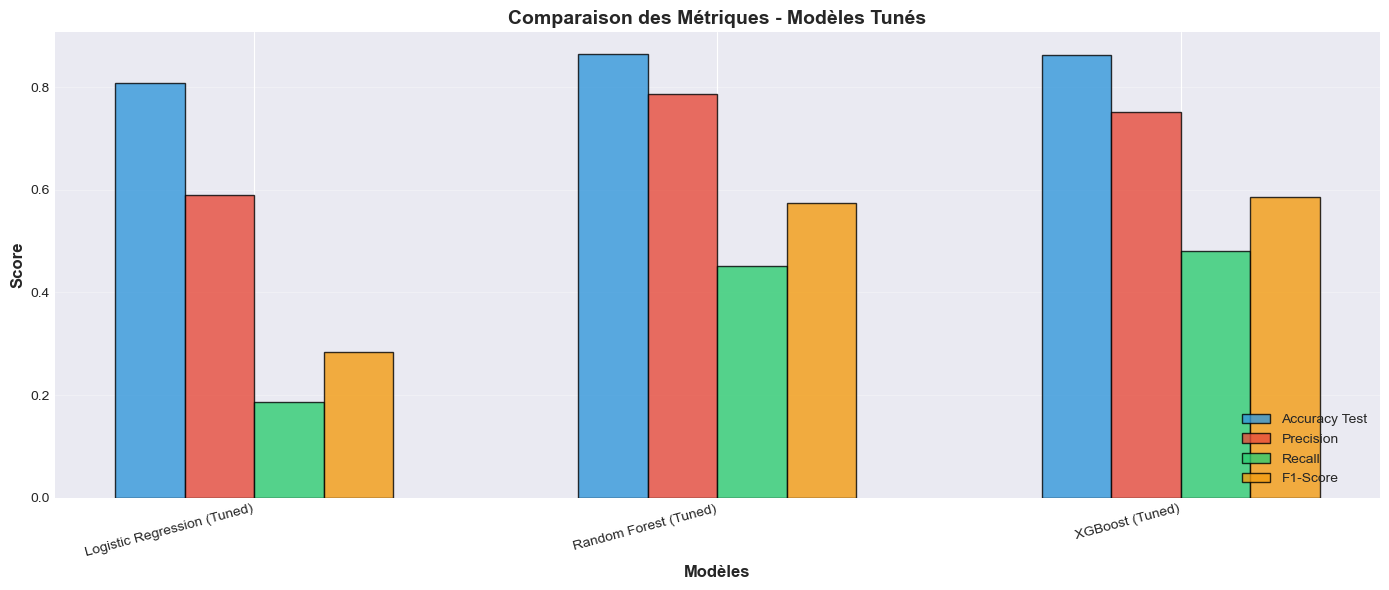

In [55]:
# Comparaison des résultats
tuned_comparison_df = pd.DataFrame(tuned_results).set_index('Modèle')

print("\n" + "="*100)
print("COMPARAISON DES MODÈLES APRÈS FINE-TUNING")
print("="*100)
print(tuned_comparison_df.to_string())

# Visualisation comparative
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(tuned_comparison_df))
width = 0.15

metrics = ['Accuracy Test', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, tuned_comparison_df[metric], width, 
           label=metric, color=color, alpha=0.8, edgecolor='black')

ax.set_xlabel('Modèles', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des Métriques - Modèles Tunés', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(tuned_comparison_df.index, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4 Courbes ROC des modèles tunés

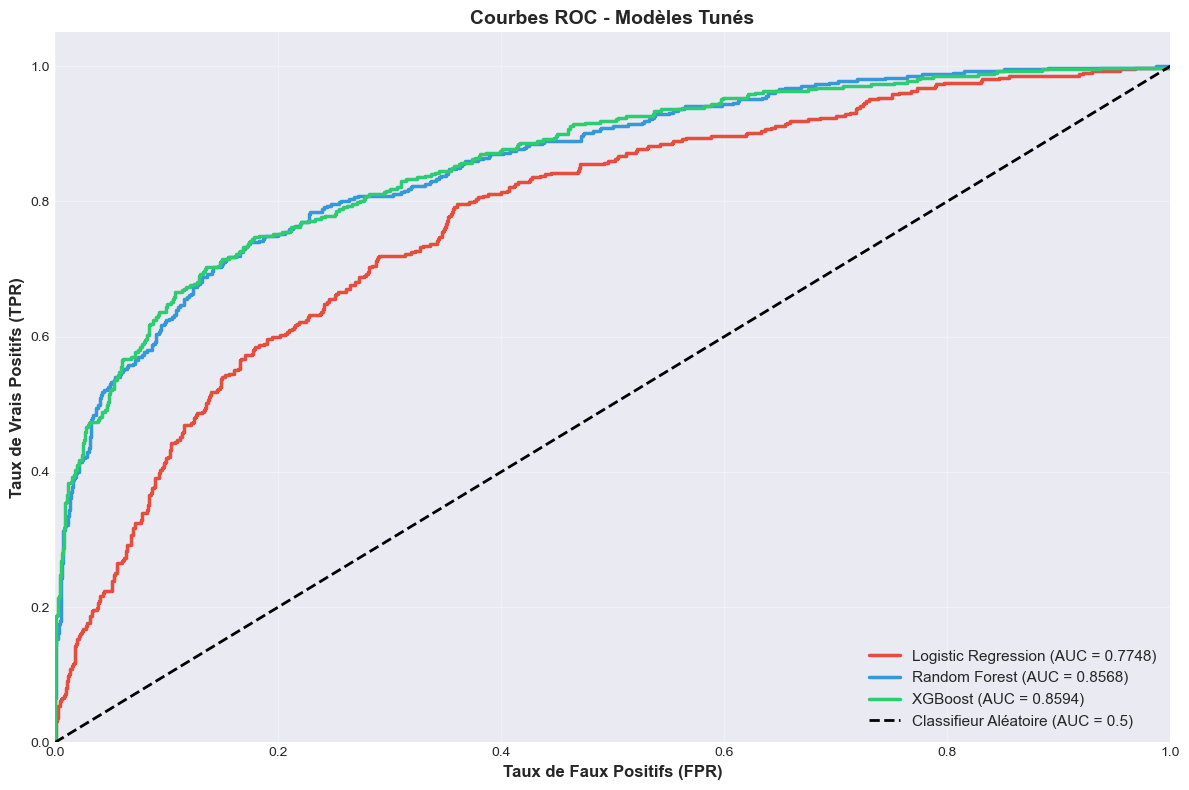


Scores ROC-AUC des modèles tunés:
Logistic Regression      : 0.7748
Random Forest            : 0.8568
XGBoost                  : 0.8594


In [56]:
# Tracer les courbes ROC pour tous les modèles tunés
plt.figure(figsize=(12, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71']

for (model_name, model), color in zip(tuned_models.items(), colors):
    # Prédictions probabilistes
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Tracer la courbe
    plt.plot(fpr, tpr, color=color, lw=2.5, 
             label=f'{model_name} (AUC = {roc_auc:.4f})')

# Ligne diagonale (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classifieur Aléatoire (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
plt.title('Courbes ROC - Modèles Tunés', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nScores ROC-AUC des modèles tunés:")
print("="*80)
for model_name, model in tuned_models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name:25s}: {roc_auc:.4f}")

---
# 5. Sélection de Caractéristiques avec SelectKBest
---

## 5.1 Sélection des K meilleures features

In [57]:
# SelectKBest avec différentes valeurs de K
k_values = [5, 7, 10]
feature_selection_results = []

for k in k_values:
    print(f"\n{'='*80}")
    print(f"SÉLECTION DES {k} MEILLEURES FEATURES")
    print(f"{'='*80}")
    
    # SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Obtenir les noms des features sélectionnées
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"\nFeatures sélectionnées ({k}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"  {i}. {feature}")
    
    # Scores des features
    feature_scores = pd.DataFrame({
        'Feature': X.columns[selector.get_support()],
        'Score': selector.scores_[selector.get_support()]
    }).sort_values('Score', ascending=False)
    
    print(f"\nScores des features:")
    print(feature_scores.to_string(index=False))
    
    # Tester avec différents modèles
    models_test = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    }
    
    for model_name, model in models_test.items():
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        feature_selection_results.append({
            'K': k,
            'Modèle': model_name,
            'Accuracy': accuracy,
            'F1-Score': f1
        })
        
        print(f"\n{model_name} avec {k} features:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score: {f1:.4f}")


SÉLECTION DES 5 MEILLEURES FEATURES

Features sélectionnées (5):
  1. Gender
  2. Age
  3. Balance
  4. IsActiveMember
  5. Geography_Germany

Scores des features:
          Feature      Score
              Age 682.383065
Geography_Germany 274.732431
   IsActiveMember 189.886490
          Balance 119.720036
           Gender  90.747805

Logistic Regression avec 5 features:
  Accuracy: 0.8040
  F1-Score: 0.2659

Random Forest avec 5 features:
  Accuracy: 0.7935
  F1-Score: 0.4158

XGBoost avec 5 features:
  Accuracy: 0.8215
  F1-Score: 0.4499

SÉLECTION DES 7 MEILLEURES FEATURES

Features sélectionnées (7):
  1. Gender
  2. Age
  3. Balance
  4. NumOfProducts
  5. IsActiveMember
  6. Geography_Germany
  7. Geography_Spain

Scores des features:
          Feature      Score
              Age 682.383065
Geography_Germany 274.732431
   IsActiveMember 189.886490
          Balance 119.720036
           Gender  90.747805
    NumOfProducts  23.793808
  Geography_Spain  23.725730

Logistic Regr

## 5.2 Visualisation des scores avec SelectKBest

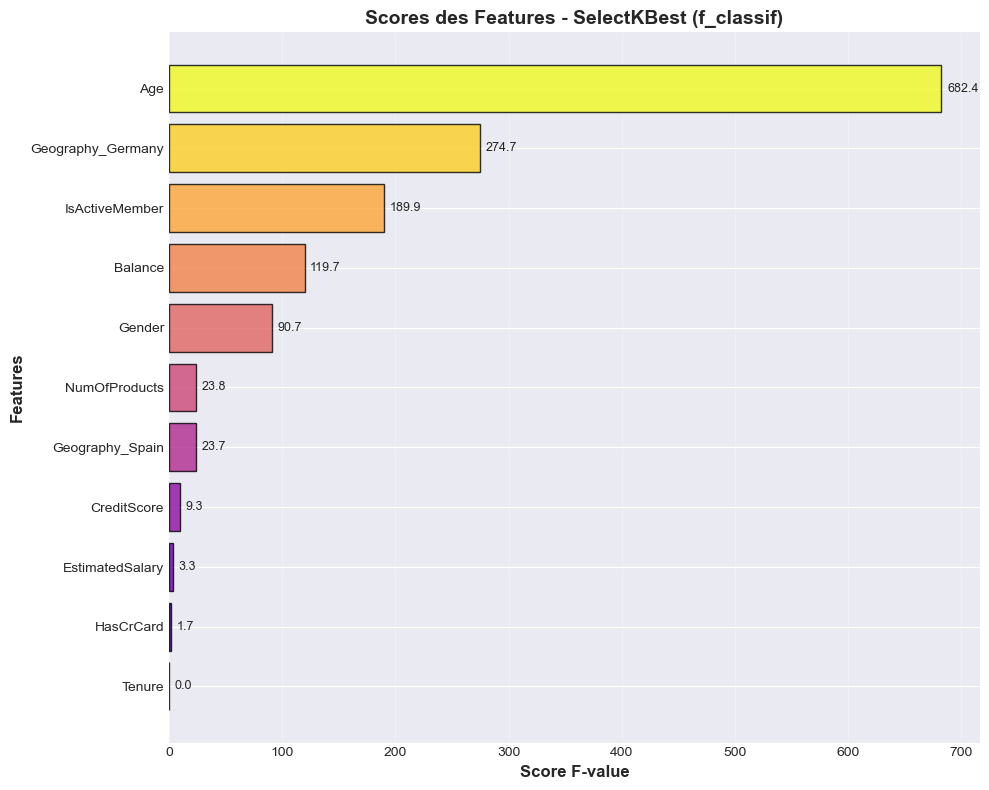

In [58]:
# Visualiser tous les scores des features
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X_train_scaled, y_train)

all_feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_all.scores_
}).sort_values('Score', ascending=True)

# Visualisation avec barres horizontales
plt.figure(figsize=(10, 8))
colors = plt.cm.plasma(np.linspace(0, 1, len(all_feature_scores)))
plt.barh(all_feature_scores['Feature'], all_feature_scores['Score'], 
         color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Score F-value', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Scores des Features - SelectKBest (f_classif)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, v in enumerate(all_feature_scores['Score']):
    plt.text(v + 5, i, f'{v:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5.3 Comparaison des performances avec différents K


RÉSULTATS DE LA SÉLECTION DE FEATURES
 K              Modèle  Accuracy  F1-Score
 5 Logistic Regression    0.8040  0.265918
 5       Random Forest    0.7935  0.415842
 5             XGBoost    0.8215  0.449923
 7 Logistic Regression    0.8105  0.291589
 7       Random Forest    0.8395  0.554785
 7             XGBoost    0.8515  0.573888
10 Logistic Regression    0.8080  0.280899
10       Random Forest    0.8585  0.569254
10             XGBoost    0.8475  0.562410


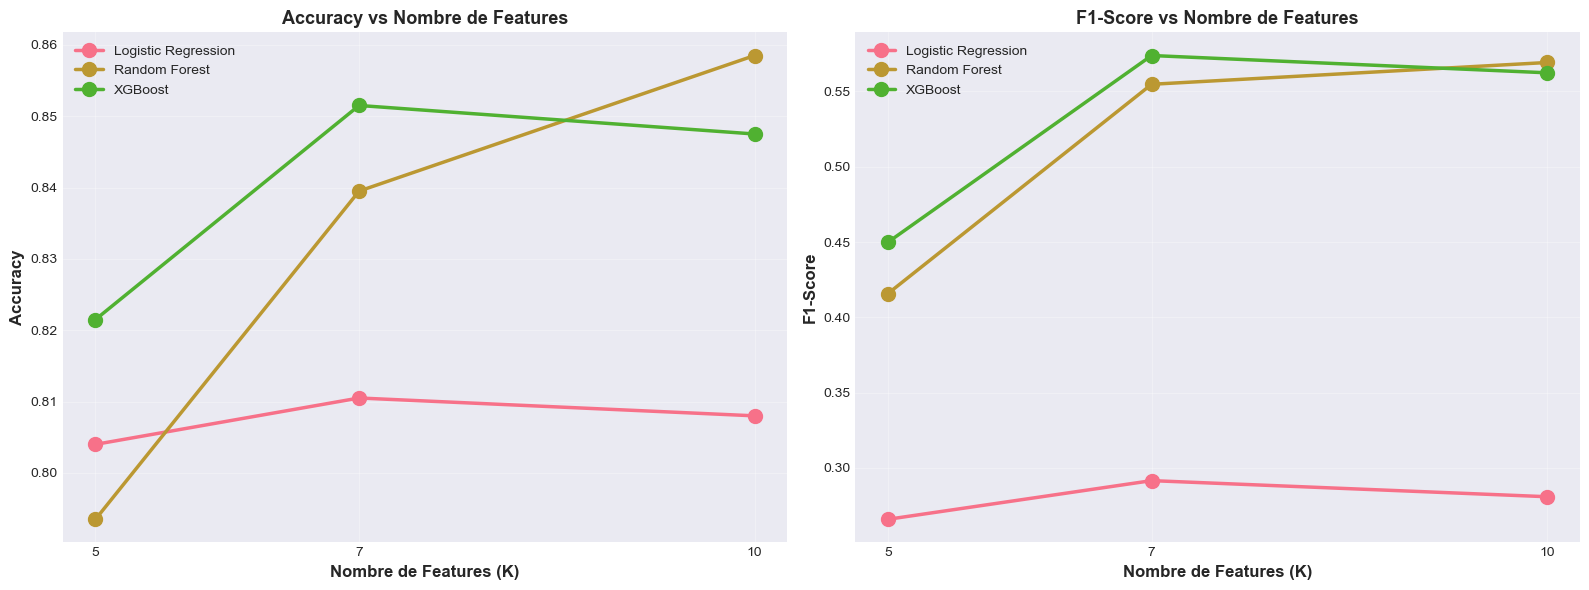

In [59]:
# Comparaison des résultats
fs_results_df = pd.DataFrame(feature_selection_results)

print("\n" + "="*100)
print("RÉSULTATS DE LA SÉLECTION DE FEATURES")
print("="*100)
print(fs_results_df.to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
for model_name in fs_results_df['Modèle'].unique():
    model_data = fs_results_df[fs_results_df['Modèle'] == model_name]
    axes[0].plot(model_data['K'], model_data['Accuracy'], 
                marker='o', linewidth=2.5, markersize=10, label=model_name)

axes[0].set_xlabel('Nombre de Features (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy vs Nombre de Features', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_values)

# F1-Score
for model_name in fs_results_df['Modèle'].unique():
    model_data = fs_results_df[fs_results_df['Modèle'] == model_name]
    axes[1].plot(model_data['K'], model_data['F1-Score'], 
                marker='o', linewidth=2.5, markersize=10, label=model_name)

axes[1].set_xlabel('Nombre de Features (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score vs Nombre de Features', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

---
# 6. Conclusion
---

In [60]:
print("\n" + "="*100)
print(" "*35 + "RAPPORT FINAL - ANALYSE DU CHURN")
print("="*100)

print("\n📊 RÉSUMÉ DE L'ANALYSE:")
print("-" * 100)

print("\n1. EXPLORATION DES DONNÉES (EDA):")
print("   • Dataset de", df.shape[0], "clients avec", df.shape[1], "variables")
print("   • Taux de churn:", f"{(df['Exited'].sum() / len(df) * 100):.2f}%")
print("   • Variables numériques:", len(numerical_cols))
print("   • Variables catégoriques:", len(categorical_cols))
print("   • Pas de valeurs manquantes détectées")
print("   • Variables les plus corrélées avec le churn: Age, NumOfProducts, IsActiveMember")

print("\n2. PREPROCESSING:")
print("   • Suppression des colonnes non pertinentes (RowNumber, CustomerId, Surname)")
print("   • Encodage des variables catégoriques (LabelEncoder + One-Hot Encoding)")
print("   • Normalisation avec StandardScaler")
print("   • Split Train/Test: 80/20")

print("\n3. MODÉLISATION BASELINE:")
print("-" * 100)
print(comparison_df[['Accuracy Test', 'F1-Score', 'ROC-AUC']].to_string())

best_baseline = comparison_df['F1-Score'].idxmax()
best_baseline_score = comparison_df['F1-Score'].max()
print(f"\n   ✓ Meilleur modèle baseline: {best_baseline} (F1-Score: {best_baseline_score:.4f})")

print("\n4. FINE-TUNING:")
print("-" * 100)
print(tuned_comparison_df[['Accuracy Test', 'F1-Score', 'ROC-AUC']].to_string())

best_tuned = tuned_comparison_df['F1-Score'].idxmax()
best_tuned_score = tuned_comparison_df['F1-Score'].max()
print(f"\n   ✓ Meilleur modèle après tuning: {best_tuned} (F1-Score: {best_tuned_score:.4f})")

improvement = ((best_tuned_score - best_baseline_score) / best_baseline_score) * 100
print(f"   ✓ Amélioration du F1-Score: {improvement:+.2f}%")

print("\n5. SÉLECTION DE FEATURES:")
print(f"   • Méthode: SelectKBest avec f_classif")
print(f"   • Tests effectués avec K = {k_values}")

best_fs = fs_results_df.loc[fs_results_df['F1-Score'].idxmax()]
print(f"\n   ✓ Meilleure configuration: {best_fs['Modèle']} avec K={int(best_fs['K'])} features")
print(f"   ✓ F1-Score obtenu: {best_fs['F1-Score']:.4f}")

print("\n" + "="*100)
print("🎯 RECOMMANDATIONS FINALES:")
print("="*100)

print("\n1. MODÈLE RECOMMANDÉ:")
print(f"   Le modèle {best_tuned} après fine-tuning offre les meilleures performances")
print(f"   avec un F1-Score de {best_tuned_score:.4f} et un ROC-AUC de {tuned_comparison_df.loc[best_tuned, 'ROC-AUC']:.4f}")

print("\n2. FEATURES IMPORTANTES:")
print("   Les variables les plus prédictives du churn sont:")
top_features = all_feature_scores.tail(5)
for idx, row in top_features.iterrows():
    print(f"   • {row['Feature']}: Score = {row['Score']:.2f}")

print("\n3. ACTIONS BUSINESS:")
print("   • Surveiller particulièrement les clients âgés")
print("   • Encourager l'utilisation active des services")
print("   • Optimiser l'offre de produits (attention au nombre trop élevé)")
print("   • Analyser les différences géographiques")
print("   • Mettre en place des campagnes de rétention ciblées")

print("\n4. PROCHAINES ÉTAPES:")
print("   • Déployer le modèle en production")
print("   • Mettre en place un monitoring des performances")
print("   • Réentraîner régulièrement avec de nouvelles données")
print("   • Tester des techniques d'ensemble learning avancées")
print("   • Explorer des méthodes de gestion du déséquilibre de classes (SMOTE, etc.)")

print("\n" + "="*100)
print(" "*30 + "FIN DE L'ANALYSE - DATA SCIENCE PROJECT")
print("="*100 + "\n")


                                   RAPPORT FINAL - ANALYSE DU CHURN

📊 RÉSUMÉ DE L'ANALYSE:
----------------------------------------------------------------------------------------------------

1. EXPLORATION DES DONNÉES (EDA):
   • Dataset de 10000 clients avec 14 variables
   • Taux de churn: 20.37%
   • Variables numériques: 8
   • Variables catégoriques: 2
   • Pas de valeurs manquantes détectées
   • Variables les plus corrélées avec le churn: Age, NumOfProducts, IsActiveMember

2. PREPROCESSING:
   • Suppression des colonnes non pertinentes (RowNumber, CustomerId, Surname)
   • Encodage des variables catégoriques (LabelEncoder + One-Hot Encoding)
   • Normalisation avec StandardScaler
   • Split Train/Test: 80/20

3. MODÉLISATION BASELINE:
----------------------------------------------------------------------------------------------------
                     Accuracy Test  F1-Score   ROC-AUC
Modèle                                                
K-Nearest Neighbors          0.8

---

## 📝 Notes Finales

Ce notebook a présenté une analyse complète de prédiction du churn client avec:

- ✅ **EDA approfondie** avec visualisations professionnelles
- ✅ **Preprocessing complet** et rigoureux
- ✅ **5 modèles baseline** testés et comparés
- ✅ **Fine-tuning** avec GridSearchCV sur les meilleurs modèles
- ✅ **Courbes ROC** pour évaluation comparative
- ✅ **Sélection de features** avec SelectKBest
- ✅ **Recommandations business** actionnables

* **Auteurs:** Bassem Ben Hamed
* **Emails:** *bassem.benhamed@enetcom.usf.tn**
* **Date:** Février 2026  
* **Projet:** Customer Churn Prediction Analysis